In [ ]:
%pip install textblob

import pandas as pd
import numpy as np
import os
import json
import re
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

# import nltk
# nltk.download('punkt')

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
current_dir = os.getcwd()
base_path = os.path.abspath(os.path.join(current_dir, '..', '..'))
processed_data_path = os.path.join(base_path, "data", "processed", "diplomacy")
raw_moves_path = os.path.join(base_path, "data", "raw", "2020_acl_diplomacy", "moves")

print(f"Reading data from: {processed_data_path}")
print(f"Reading moves from: {raw_moves_path}")

Reading data from: c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy
Reading moves from: c:\work environment\Projects\amazon-spam-review\data\raw\2020_acl_diplomacy\moves


In [4]:
train_df = pd.read_parquet(os.path.join(processed_data_path, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(processed_data_path, "val_processed.parquet"))
test_df = pd.read_parquet(os.path.join(processed_data_path, "test_processed.parquet"))

print(f"Train shape: {train_df.shape}")

Train shape: (13132, 13)


## 1. Lingusitic Feature Engineering
Extracting features from the text itself: Sentiment, Punctuation, Pronouns.

In [5]:
def extract_linguistic_features(df):
    df_feat = df.copy()
    
    # 1. Sentiment
    df_feat['sentiment_polarity'] = df_feat['message_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_feat['sentiment_subjectivity'] = df_feat['message_text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    # 2. Punctuation Counts
    df_feat['n_question_marks'] = df_feat['message_text'].apply(lambda x: str(x).count('?'))
    df_feat['n_exclamation_marks'] = df_feat['message_text'].apply(lambda x: str(x).count('!'))
    df_feat['n_ellipses'] = df_feat['message_text'].apply(lambda x: str(x).count('...'))
    
    # 3. Pronoun Usage (approximation using regex)
    # First person singular: I, my, mine, me
    # First person plural: we, our, ours, us
    df_feat['n_i_pronouns'] = df_feat['message_text'].apply(lambda x: len(re.findall(r'\b(i|my|mine|me)\b', str(x).lower())))
    df_feat['n_we_pronouns'] = df_feat['message_text'].apply(lambda x: len(re.findall(r'\b(we|our|ours|us)\b', str(x).lower())))
    
    # 4. Text Length/Complexity
    df_feat['char_count'] = df_feat['message_text'].apply(len)
    df_feat['word_count'] = df_feat['message_text'].apply(lambda x: len(str(x).split()))
    df_feat['avg_word_length'] = df_feat['char_count'] / (df_feat['word_count'] + 1)
    df_feat['uppercase_ratio'] = df_feat['message_text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))
    
    return df_feat

print("Extracting linguistic features...")
train_df = extract_linguistic_features(train_df)
val_df = extract_linguistic_features(val_df)
test_df = extract_linguistic_features(test_df)
print("Done.")

Extracting linguistic features...
Done.


## 2. Game Move Feature Engineering
Integrating actual gameplay data from `data/raw/2020_acl_diplomacy/moves`.
We will look up the move file for each `game_id`, `year`, and `season`, then parse the orders for the `speaker`.

In [ ]:
def get_move_stats(row):
    # Construct filename: DiplomacyGame{id}_{year}_{season}.json
    filename = f"DiplomacyGame{row['game_id']}_{row['year']}_{row['season'].lower()}.json"
    file_path = os.path.join(raw_moves_path, filename)
    
    speaker_country = str(row['speaker']).capitalize() # JSON uses capitalized country names
    
    stats = {
        'n_orders': 0,
        'n_support': 0,
        'n_hold': 0,
        'n_move_fails': 0
    }
    
    if not os.path.exists(file_path):
        return pd.Series(stats)
        
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        if 'orders' in data and speaker_country in data['orders']:
            orders = data['orders'][speaker_country]
            stats['n_orders'] = len(orders)
            
            for territory, order in orders.items():
                # Order Type
                order_type = order.get('type', '')
                if 'SUPPORT' in order_type:
                    stats['n_support'] += 1
                elif 'HOLD' in order_type:
                    stats['n_hold'] += 1
                
                # Order Result
                result = order.get('result', '')
                if 'FAILS' in result:
                    stats['n_move_fails'] += 1
                    
    except Exception as e:
        pass
        
    return pd.Series(stats)

print("Extracting move features (this may take a minute)...")

# Apply to subsets for testing speed if needed, but applying to all here
train_moves = train_df.apply(get_move_stats, axis=1)
train_df = pd.concat([train_df, train_moves], axis=1)

val_moves = val_df.apply(get_move_stats, axis=1)
val_df = pd.concat([val_df, val_moves], axis=1)

test_moves = test_df.apply(get_move_stats, axis=1)
test_df = pd.concat([test_df, test_moves], axis=1)

print("Done.")

Extracting move features (this may take a minute)...
Done.


In [7]:
print(train_df[['target', 'n_question_marks', 'n_i_pronouns', 'n_support', 'n_move_fails']].head())

   target  n_question_marks  n_i_pronouns  n_support  n_move_fails
0       0                 3             9          0             0
1       0                 1             1          0             0
2       0                 0             0          0             0
3       0                 0             2          0             0
4       0                 0             9          0             0


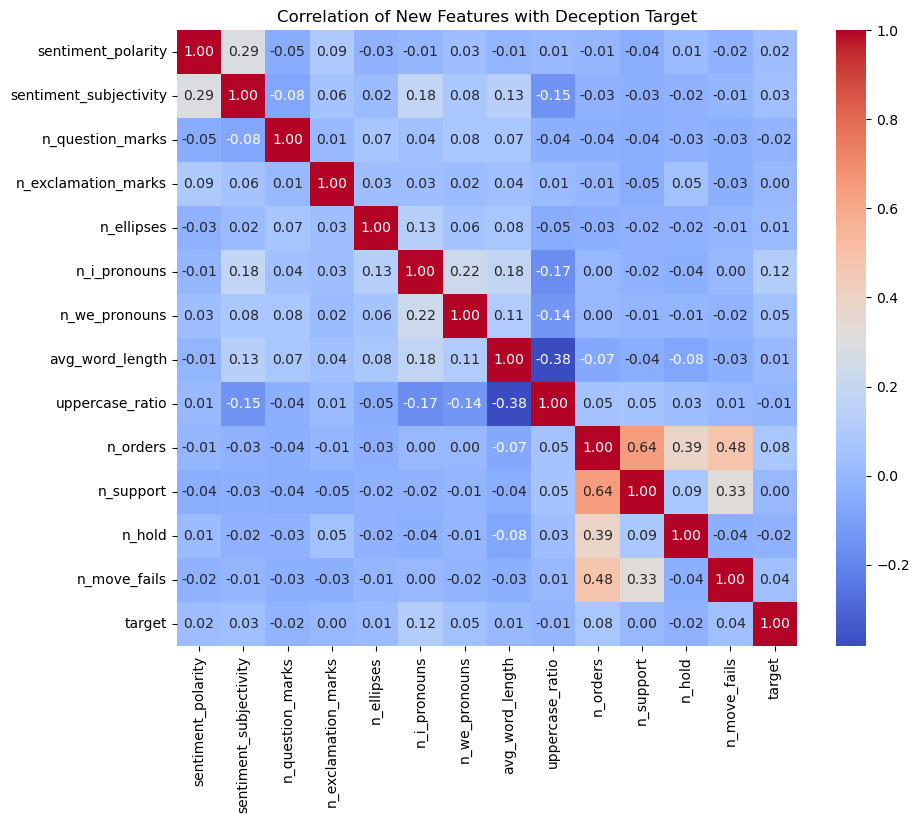

In [ ]:
# Correlation Check
new_features = ['sentiment_polarity', 'sentiment_subjectivity',
                'n_question_marks', 'n_exclamation_marks', 'n_ellipses',
                'n_i_pronouns', 'n_we_pronouns', 
                'avg_word_length', 'uppercase_ratio',
                'n_orders', 'n_support', 'n_hold', 'n_move_fails', 'target']

plt.figure(figsize=(10, 8))
sns.heatmap(train_df[new_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of New Features with Deception Target")
plt.show()

In [9]:
train_output = os.path.join(processed_data_path, "train_enriched.parquet")
val_output = os.path.join(processed_data_path, "val_enriched.parquet")
test_output = os.path.join(processed_data_path, "test_enriched.parquet")

train_df.to_parquet(train_output)
val_df.to_parquet(val_output)
test_df.to_parquet(test_output)

print(f"Saved enriched data to:\n{train_output}\n{val_output}\n{test_output}")

Saved enriched data to:
c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy\train_enriched.parquet
c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy\val_enriched.parquet
c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy\test_enriched.parquet
